In [1]:
import sys
import os
import yaml
import random
import numpy as np

sys.path.insert(0, '../')

import utils.utils as utils

from pathlib import Path

from utils.data_utils import get_gen
from utils.plotting import (plot_tsne_by_cluster, plot_group_kaplan_meier, plot_bigroup_kaplan_meier, 
                            plot_tsne_by_survival)
from utils.eval_utils import cindex, calibration, accuracy_metric, cindex_metric
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score

from datasets.survivalMNIST.survivalMNIST_data import generate_surv_MNIST

# TensorFlow imports
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfkl = tf.keras.layers
tfpl = tfp.layers
tfk = tf.keras

# VaDeSC model
from models.losses import Losses
from models.model import GMM_Survival

import matplotlib.pyplot as plt

%matplotlib inline

/local/home/anaconda3/envs/Survival_Cluster_Analysis/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [2]:
def setup_seed(seed):
    random.seed(seed)  
    np.random.seed(seed) 
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  

In [3]:
# Fix random seed
seed = 20220229
setup_seed(seed)

### survMNIST Data

In [4]:
# Generate survival MNIST data
x_train, x_test, t_train, t_test, d_train, d_test, c_train, c_test =\
    generate_surv_MNIST(n_groups=5, seed=seed, p_cens=0.3, valid_perc=0)

# Normalise images
x_train = x_train / 255.
x_test = x_test / 255.

# Wrap t, d, and c together
y_train = np.stack([t_train, d_train, c_train], axis=1)
y_test = np.stack([t_test, d_test, c_test], axis=1)

--------------------------------------------------
Cluster Assignments & Risk Scores:
Digit:       [0 1 2 3 4 5 6 7 8 9]
Risk group:  [0 0 3 2 0 4 3 1 1 1]
Risk score:  [ 3.31123304  3.31123304  1.86252627 10.29560333  3.31123304  6.21324987
  1.86252627  8.75617551  8.75617551  8.75617551]
--------------------------------------------------




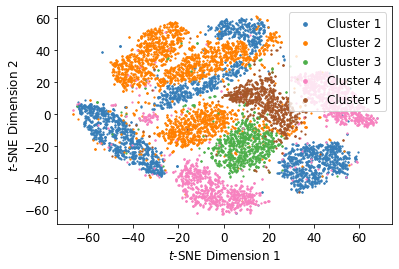

In [5]:
# Visualise t-SNE of images colour data points according to the cluster
plot_tsne_by_cluster(X=x_train, c=c_train, font_size=12, seed=42)

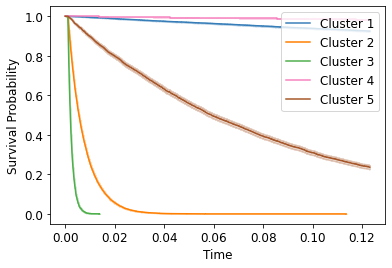

In [6]:
# Plot cluster-specific Kaplan-Meier curves
plot_group_kaplan_meier(t=t_train, d=d_train, c=c_train)

### VaDeSC Model

In [7]:
# Load config file for the MNIST
project_dir = os.path.dirname(os.getcwd())
config_path = Path(os.path.join(project_dir, 'configs/mnist.yml'))
with config_path.open(mode='r') as yamlfile:
    configs = yaml.safe_load(yamlfile)
print(configs)

{'data': {'data_name': 'MNIST'}, 'training': {'eval_frequency': 200, 'inp_shape': 784, 'latent_dim': 16, 'activation': 'sigmoid', 'monte_carlo': 1, 'num_clusters': 5, 'learn_prior': True, 'weibull_shape': 1, 'survival': True, 'sample_surv': True}}


In [8]:
# Define reconstruction loss function
losses = Losses(configs)
rec_loss = losses.loss_reconstruction_binary

In [9]:
# Fix seeds
setup_seed(seed)

In [10]:
# Construct the model & optimizer
model = GMM_Survival(**configs['training'])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.00001)
model.compile(optimizer, loss={"output_1": rec_loss}, 
              metrics={"output_4": accuracy_metric, "output_5": cindex_metric})
# Use survival times during training
tf.keras.backend.set_value(model.use_t, np.array([1.0]))

In [11]:
# Data generators
gen_train = get_gen(x_train, y_train, configs, 256)
gen_test = get_gen(x_test, y_test, configs, 256, validation=True)

### Training & Evaluation

In [12]:
# Fit the model
model.fit(gen_train, validation_data=gen_test, epochs=300, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When f

In [13]:
# Evaluate the model 

# Don't use survival times during testing
tf.keras.backend.set_value(model.use_t, np.array([0.0]))

# Don't use MC samples to predict survival at evaluation
model.sample_surv = False

rec, z_sample, p_z_c, p_c_z, risk_scores, lambdas = model.predict((x_train, y_train), batch_size=256)
risk_scores = np.squeeze(risk_scores)
# Hard cluster assignments
c_hat = np.argmax(p_c_z, axis=-1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


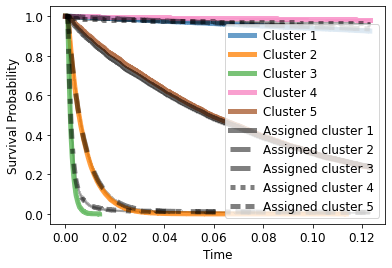

In [19]:
# Plot cluster-specific Kaplan-Meier curves alongside ground truth
plot_bigroup_kaplan_meier(t=t_train, d=d_train, c_=c_hat, c=c_train, legend=True)

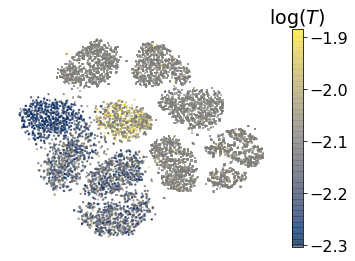

In [20]:
# Visualise learnt representations
plot_tsne_by_survival(X=z_sample[:, 0], t=y_train[:, 0], d=y_train[:, 1], seed=42, plot_censored=True)

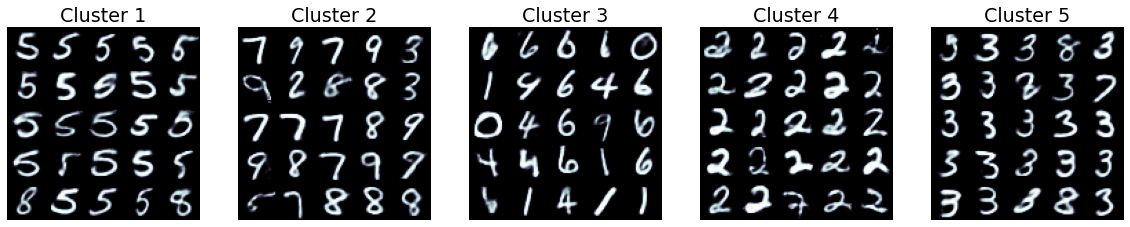

In [21]:
# Visualise generated samples for each cluster
fig, ax = plt.subplots(1, model.num_clusters, figsize=(20,100))

grid_size = 5
inp_size = (28, 28)

for j in range(model.num_clusters):
    samples = model.generate_samples(j=j, n_samples=grid_size**2)
    cnt = 0
    img = None
    for k in range(grid_size):
        row_k = []
        for l in range(grid_size):
            row_k.append(np.reshape(samples[0, cnt, :], (inp_size[0], inp_size[1])))
            cnt = cnt + 1
        if img is None:
            img = np.concatenate(row_k, axis=1)
        else:
            img = np.concatenate([img, np.concatenate(row_k, axis=1)], axis=0)
    ax[j].set_title('Cluster ' + str(j + 1))
    ax[j].imshow(img, cmap='bone')
    ax[j].axis('off')

In [22]:
# Evaluate some metrics on the training data
acc = utils.cluster_acc(y_train[:, 2], c_hat)
nmi = normalized_mutual_info_score(y_train[:, 2], c_hat)
ari = adjusted_rand_score(y_train[:, 2], c_hat)
ci = cindex(t=y_train[:, 0], d=y_train[:, 1], scores_pred=risk_scores)
print('ACC: {:.2f}; NMI: {:.2f}; ARI: {:.2f}; CI (tr.): {:.2f}'.format(acc,nmi, ari, ci))

/local/home/anaconda3/envs/Survival_Cluster_Analysis/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


ACC: 0.87; NMI: 0.76; ARI: 0.73; CI (tr.): 0.88


In [23]:
# Now, on the test data
rec, z_sample, p_z_c, p_c_z, risk_scores, lambdas = model.predict((x_test, y_test), batch_size=256)
risk_scores = np.squeeze(risk_scores)
# Hard cluster assignments
c_hat = np.argmax(p_c_z, axis=-1)
acc = utils.cluster_acc(y_test[:, 2], c_hat)
nmi = normalized_mutual_info_score(y_test[:, 2], c_hat)
ari = adjusted_rand_score(y_test[:, 2], c_hat)
ci = cindex(t=y_test[:, 0], d=y_test[:, 1], scores_pred=risk_scores)
print('ACC: {:.2f}; NMI: {:.2f}; ARI: {:.2f}; CI (te.): {:.2f}'.format(acc,nmi, ari, ci))

ACC: 0.86; NMI: 0.74; ARI: 0.72; CI (te.): 0.84


/local/home/anaconda3/envs/Survival_Cluster_Analysis/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
